100%|██████████| 9912422/9912422 [00:00<00:00, 62579057.85it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 50452184.02it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29430702.70it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4968839.01it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Epoch [0/50], Step [200/600], d_loss: 0.0593, g_loss: 4.2278, D(x): 0.98, D(G(z)): 0.04
Epoch [0/50], Step [400/600], d_loss: 0.2423, g_loss: 4.6922, D(x): 0.90, D(G(z)): 0.10
Epoch [0/50], Step [600/600], d_loss: 0.0291, g_loss: 5.4397, D(x): 0.99, D(G(z)): 0.01
Epoch [1/50], Step [200/600], d_loss: 0.0618, g_loss: 4.8822, D(x): 0.98, D(G(z)): 0.03
Epoch [1/50], Step [400/600], d_loss: 0.0942, g_loss: 4.9997, D(x): 0.96, D(G(z)): 0.05
Epoch [1/50], Step [600/600], d_loss: 0.5372, g_loss: 3.5893, D(x): 0.94, D(G(z)): 0.29
Epoch [2/50], Step [200/600], d_loss: 1.8620, g_loss: 1.6612, D(x): 0.72, D(G(z)): 0.67
Epoch [2/50], Step [400/600], d_loss: 0.3427, g_loss: 3.5886, D(x): 0.89, D(G(z)): 0.11
Epoch [2/50], Step [600/600], d_loss: 0.1811, g_loss: 4.5142, D(x): 0.94, D(G(z)): 0.08
Epoch [3/50], Step [200/600], d_loss: 0.4548, g_loss: 3.1289, D(x): 0.87, D(G(z)): 0.17
Epoch [3/50], Step [400/600], d_loss: 0.2025, g_loss: 3.7950, D(x): 0.92, D(G(z)): 0.06
Epoch [3/50], Step [600/600], d_

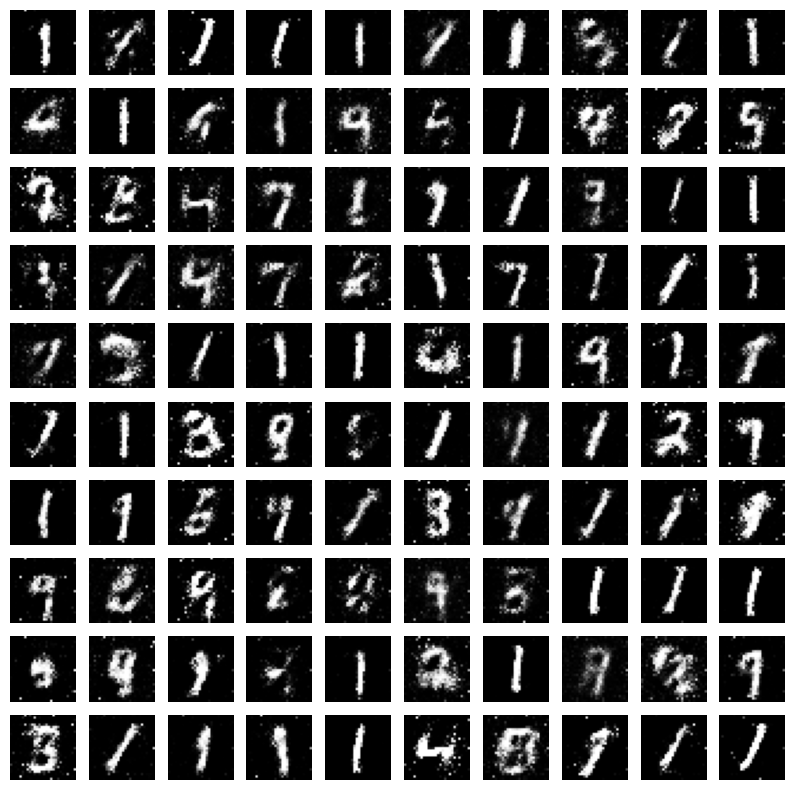

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
latent_size = 64
hidden_size = 256
image_size = 784  # 28x28 for MNIST
num_epochs = 50
batch_size = 100
learning_rate = 0.0002

# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Discriminator network
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
).to(device)

# Generator network
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()
).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=learning_rate)
g_optimizer = optim.Adam(G.parameters(), lr=learning_rate)

# Training
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        images = images.reshape(batch_size, -1).to(device)

        # Create labels for real and fake images
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train discriminator
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train generator
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        g_loss = criterion(outputs, real_labels)

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, len(train_loader), d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

# Generate and save a sample of generated images
z = torch.randn(100, latent_size).to(device)
fake_images = G(z).view(-1, 28, 28).detach().cpu().numpy()

fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(fake_images[i], cmap='gray')
    ax.axis('off')
plt.show()


Importing Libraries: The code starts by importing necessary libraries including PyTorch and its modules for neural networks and optimization, as well as torchvision for working with datasets and transforms, NumPy for numerical computations, and Matplotlib for visualization.

Device Configuration: It checks whether CUDA is available, which means it checks if a GPU is available for computation. If CUDA is available, it sets the device to CUDA, otherwise to CPU.

Hyperparameters: It defines various hyperparameters such as latent_size (size of the random noise vector fed into the generator), hidden_size (size of the hidden layers in both generator and discriminator), image_size (size of the input images, which is 28x28 for MNIST), num_epochs (number of training epochs), batch_size (number of samples per batch), and learning_rate (learning rate for the optimizer).

MNIST Dataset: It defines transformations for the MNIST dataset, which include converting images to tensors and normalizing their pixel values to the range [-1, 1]. Then it loads the MNIST training dataset using torchvision.

DataLoader: It creates a DataLoader object to iterate over the dataset during training, with shuffling enabled.

Discriminator Network (D): It defines the architecture of the discriminator neural network. The discriminator takes an image as input and outputs a single scalar value indicating the probability of the input being real (1) or fake (0). It consists of fully connected layers followed by leaky ReLU activation functions (to introduce non-linearity) and a Sigmoid activation function in the final layer to squash the output to the range [0, 1], representing probabilities.

Generator Network (G): It defines the architecture of the generator neural network. The generator takes a random noise vector as input and generates an image. It also consists of fully connected layers followed by ReLU activation functions, with a Tanh activation function in the final layer to ensure that the generated pixel values are within the range [-1, 1].

Loss Function and Optimizers: It defines the binary cross-entropy loss function (BCELoss) which is commonly used for binary classification problems. It also initializes optimizers for both the discriminator and generator networks using the Adam optimizer.

Training Loop: It iterates over the dataset for a number of epochs. In each epoch, it iterates over batches of real images from the dataset. For each batch, it performs the following steps:

Discriminator Training: It first trains the discriminator. It computes the loss for real and fake images separately, then computes the total loss by summing them up. It updates the discriminator parameters based on this loss.
Generator Training: It then trains the generator. It generates fake images from random noise vectors, passes them through the discriminator, computes the loss based on the discriminator's output (trying to fool the discriminator into classifying the fake images as real), and updates the generator parameters based on this loss.
Logging: It prints out the training progress including the epoch, batch, discriminator loss (d_loss), generator loss (g_loss), and the average scores given by the discriminator for real and fake images (D(x) and D(G(z))).

Generating Sample Images: After training, it generates a batch of fake images from random noise vectors using the trained generator. It then visualizes these generated images using Matplotlib.

This code implements a Generative Adversarial Network (GAN) using PyTorch to generate handwritten digit images resembling those from the MNIST dataset. The GAN framework consists of a generator and a discriminator network that are trained simultaneously in a competitive setting, where the generator learns to produce realistic images to fool the discriminator, and the discriminator learns to distinguish between real and fake images.